In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%load_ext Cython
# line profiler prints line by line timings, more details here
# http://mortada.net/easily-profile-python-code-in-jupyter.html
# and for use with cython, here
# http://nbviewer.jupyter.org/gist/tillahoffmann/296501acea231cbdf5e7
%load_ext line_profiler

In [2]:
#this allows line profiler (via ipython magic %lprun) to profile cython functions
from Cython.Compiler.Options import get_directive_defaults

get_directive_defaults()['linetrace'] = True
get_directive_defaults()['binding'] = True

In [42]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
from __main__ import plotSim

cdef list particles=[]

cdef class particleClass:
    cdef:
        public np.ndarray pos,vel,acc
        public double m
        public int index
    def __init__(self,index):
        self.pos=np.zeros(3,dtype=float)
        self.vel=np.zeros(3,dtype=float)
        self.acc=np.zeros(3,dtype=float)
        self.m=0
        self.index=index
    def updateX(self,dt,boxSize):
        self.pos=(self.pos + self.vel*dt) % boxSize
    def updateV(self,dt):
        #print('acceleration: ',self.acc)
        self.vel=self.vel + self.acc*dt
    def updateA(self,boxSize):
        self.acc=findAcc(self,boxSize)
        
cpdef list initSim(nParticles,boxSize):
    pMass=1 #mass of each particle
    global particles
    particles=[]
    for i in range(nParticles):
        newP=particleClass(i)
        newP.pos=boxSize*np.random.random(3)
        newP.vel=boxSize*np.sign(1-2*np.random.random(3)) # units be damned...
        newP.m=pMass
        particles.append(newP)
    return particles

def runSim(boxSize,dt,endTime,nPlots): #simple leapfrog integration
    nTimestep=int(endTime/dt)
    for i in range(nTimestep):
        for p in particles: #to do leapfrog integration you need to update all positions
            p.updateX(dt,boxSize)
        for p in particles: #then compute new accelerations on the evolved system
            p.updateA(boxSize)
            p.updateV(dt)
        if (i%int(nTimestep/nPlots)==0): #periodically plots the state of the box
            plotSim(particles,i*dt,i/int(nTimestep/nPlots))

cdef np.ndarray findAcc(object thisParticle,double boxSize):
    cdef double[3] pos=thisParticle.pos
    cdef double[3] particlePos
    cdef double particleMass
    cdef int index=thisParticle.index
    cdef double[3] acc=np.zeros(3,dtype=float)
    cdef double[3] r_vect=np.zeros(3,dtype=float)
    cdef double r=0,dx=0
    cdef int i,whichP
    cdef nP=len(particles)
    for whichP in range(nP):
        particlePos=particles[whichP].pos
        particleMass=particles[whichP].m
        #if (p.index == index): # the particle should feel no force from itself
        #    continue
        r=0
        for i in range(3): #checks periodic boundary conditions
            dx=pos[i]-particlePos[i]
            if (dx > boxSize/2):
                dx-=boxSize
            elif (dx < -boxSize/2):
                dx+=boxSize
            r+=dx**2
            r_vect[i]=dx
        if (r==0): # the particle should feel no force from itself
            continue 
        r=r**0.5+0.1 #0.1 is gravitational softening length
        factor=(-particleMass/(r**3))
        for i in range(3):
            acc[i]=factor*r_vect[i] # == GM/r^3 _r_ in units where G=1
    return np.asarray(acc)

In [29]:
def plotSim(particles,time,whichPlot):
    fig1=plt.subplot(grid[int(whichPlot),0])
    fig1.set_xlim(0,boxSize)
    fig1.set_ylim(0,boxSize)
    fig1.set_xlabel("x")
    fig1.set_ylabel("y")
    fig1.set_title('t='+str(time))
    v=np.zeros(len(particles))
    for i,p in enumerate(particles):
        pos=p.pos
        fig1.scatter(pos[0],pos[1],color=cmap(p.index/nParticles),s=1)
        #optionally add velocities, currently not very readable
        #fig1.quiver(p.pos[0],p.pos[1],p.vel[0],p.vel[1])
        v[i]=np.linalg.norm(p.vel)
    fig2=plt.subplot(grid[int(whichPlot),1])
    maxV=5*np.mean(v)
    nBin=20
    fig2.set_xlim(0,maxV)
    fig2.hist(v,bins=nBin,range=(0,maxV),color=cmap(0.7),edgecolor=cmap(0.7))
    fig2.set_xlabel("v")
    fig2.set_ylabel("n(v)")


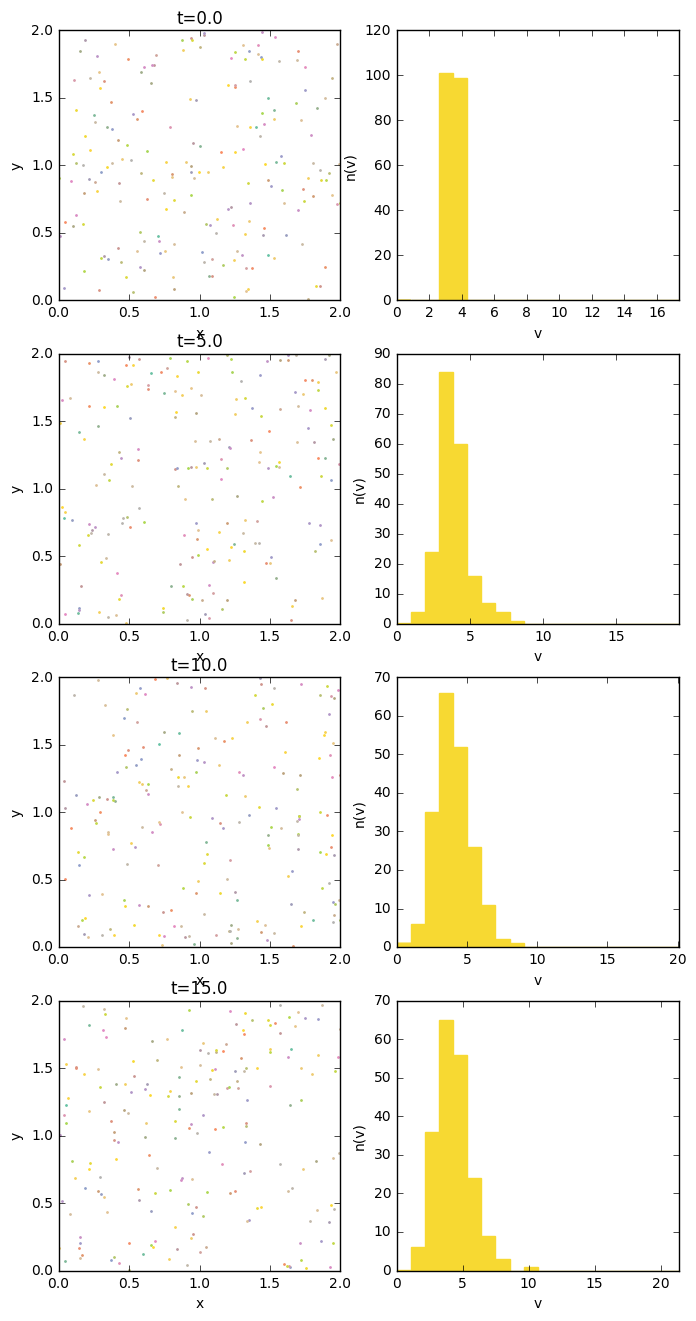

In [43]:
nParticles=200
boxSize=2
dt=0.25 # in units where G=1
endTime=20
# in these units it takes roughly t=80 for two particles of mass 1 
# to cross corner to corner of boxSize=10 and come to rest

nPlots=4
plots=plt.figure(figsize=(8,nPlots*4))
grid=matplotlib.gridspec.GridSpec(nPlots,2)
cmap=matplotlib.cm.get_cmap('Set2')


initSim(nParticles,boxSize)
# %lprun will analyse a particular funtion (i.e. "-f functionName")
# WITHIN your funtion call
%lprun -f runSim runSim(boxSize,dt,endTime,nPlots)

plt.show()